In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

2024-12-14 18:38:39.402650: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "pictures",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6284 files belonging to 8 classes.


In [4]:
class_names = dataset.class_names
class_names

['Healthy_Leaf',
 'Healthy_Nut',
 'Healthy_Trunk',
 'Stem_bleeding',
 'bud borer',
 'healthy_foot',
 'stem cracking',
 'yellow leaf disease']

In [5]:
len(dataset)

197

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 7 1 0 7 7 2 2 1 0 1 6 1 6 2 6 1 1 6 2 2 7 0 0 1 0 2 2 2 7 7 1]


2024-12-14 18:38:44.890795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-12-14 18:38:45.452677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


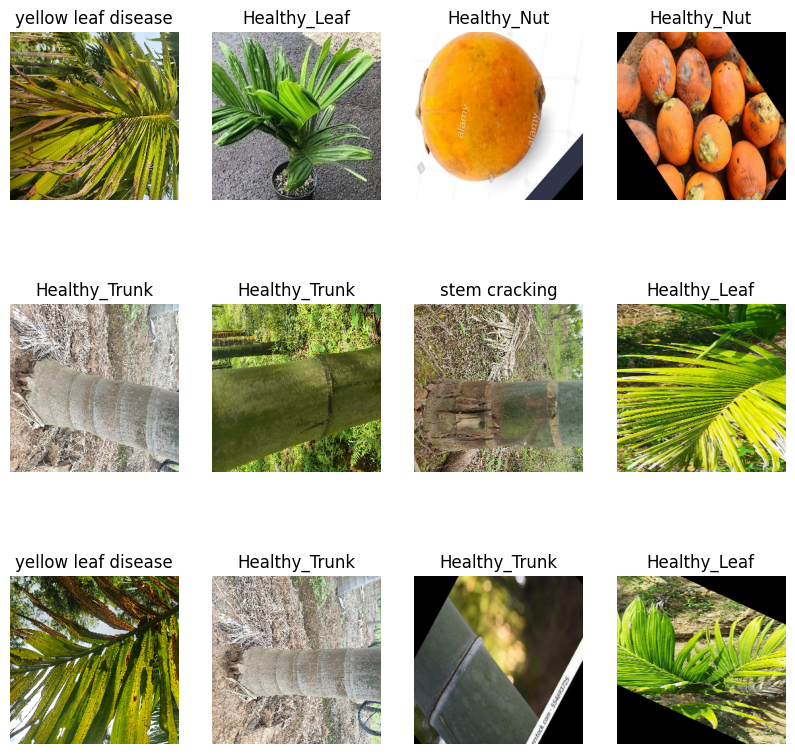

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

197

In [9]:
train_size = 0.8
len(dataset)*train_size

157.60000000000002

In [10]:
train_ds = dataset.take(221)
len(train_ds)

197

In [11]:
test_ds = dataset.skip(221)
len(test_ds)

0

In [12]:
val_size=0.1
len(dataset)*val_size

19.700000000000003

In [13]:
val_ds = test_ds.take(27)
len(val_ds)

0

In [14]:
test_ds = test_ds.skip(27)
len(test_ds)

0

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

157

In [18]:
len(val_ds)

19

In [19]:
len(test_ds)

21

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

/Users/sinchanaa/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 9)                │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,137 (719.29 KB)

 Trainable params: 184,137 (719.29 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.4237 - loss: 1.4561 - val_accuracy: 0.6283 - val_loss: 0.9402
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.5891 - loss: 0.9869 - val_accuracy: 0.6266 - val_loss: 0.8670
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6509 - loss: 0.8823 - val_accuracy: 0.6908 - val_loss: 0.7665
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.6932 - loss: 0.7896 - val_accuracy: 0.6990 - val_loss: 0.7831
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.7324 - loss: 0.6916 - val_accuracy: 0.7845 - val_loss: 0.5956
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.7575 - loss: 0.6324 - val_accuracy: 0.7681 - val_loss: 0.6273
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.7953 - loss: 0.5777 - val_accuracy: 0.7862 - val_loss: 0.5367
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8051 - loss: 0.5355 - val_accu

In [28]:
scores = model.evaluate(test_ds)

21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 222ms/step - accuracy: 0.9540 - loss: 0.1723


In [29]:
scores

[0.1651822179555893, 0.953987717628479]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 157}

In [32]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

20

In [35]:
history.history['loss'][:5]

[1.2242014408111572,
 0.9741918444633484,
 0.8636338710784912,
 0.7743183970451355,
 0.6809720396995544]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

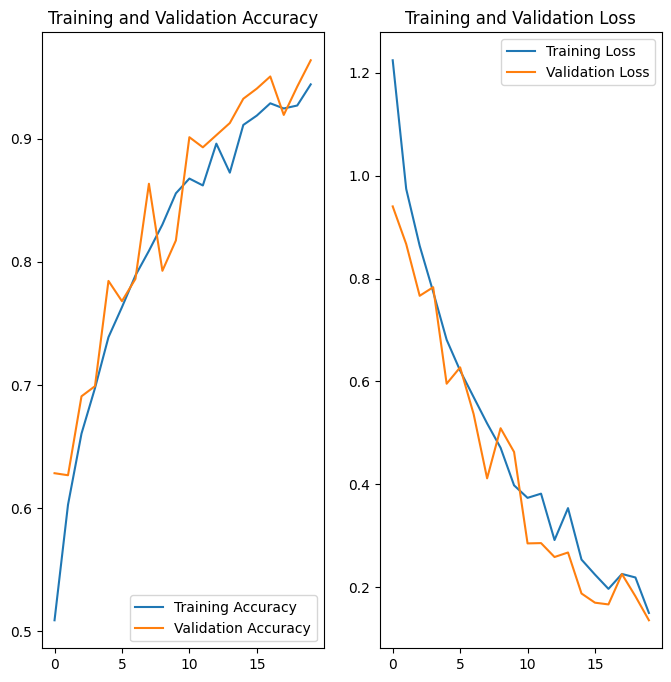

In [37]:
EPOCHS=20
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: yellow leaf disease
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
predicted label: yellow leaf disease


2024-12-14 19:36:44.104417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


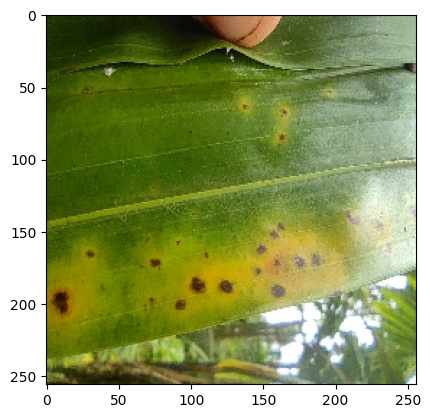

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


2024-12-14 19:36:45.346930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


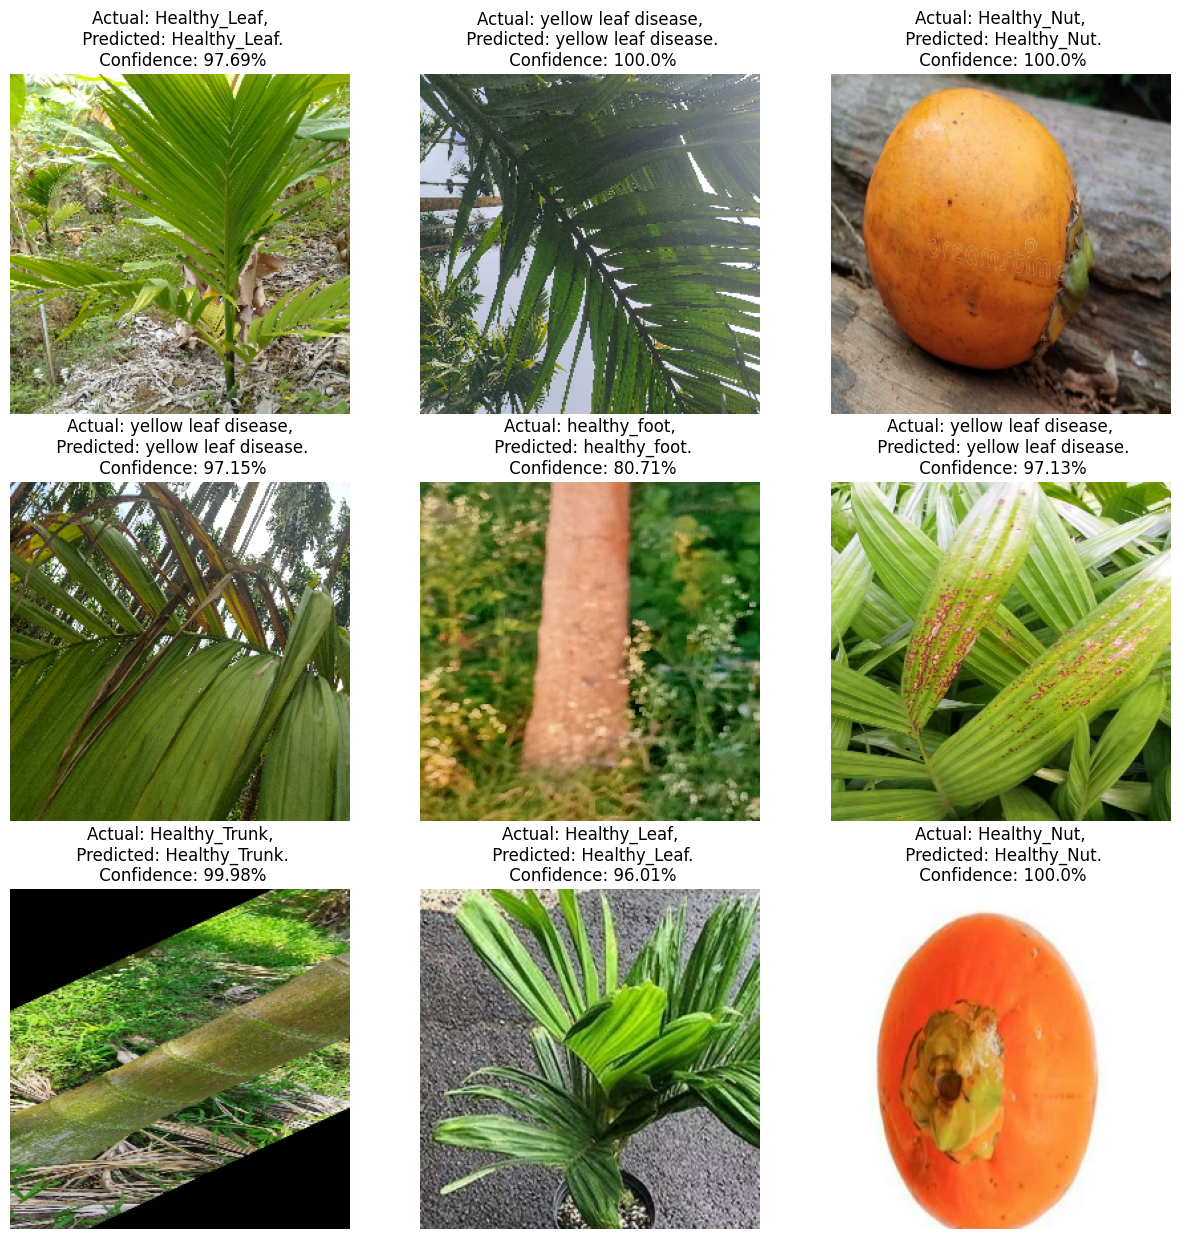

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [41]:
import os

models_dir = "../models"

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

# Determine the next model version
model_version = max([int(i) for i in os.listdir(models_dir) if i.isdigit()] + [0]) + 1

# Save the model with a valid extension
model.save(f"{models_dir}/{model_version}.keras")

print(f"Model saved at {models_dir}/{model_version}.keras")



Model saved at ../models/1.keras


In [42]:
import os

models_dir = "../models"

# Ensure the directory exists
os.makedirs(models_dir, exist_ok=True)

# Determine the next model version
model_version = max([int(i) for i in os.listdir(models_dir) if i.isdigit()] + [0]) + 1

# Save the model using the recommended `.keras` format
model.save(f"{models_dir}/{model_version}.keras")

print(f"Model saved at {models_dir}/{model_version}.keras")


Model saved at ../models/1.keras
